# Notas sobre procesamiento digital de señales aplicado al análisis de vibraciones mecánicas

## Elaborado por Mag. Luis Sánchez Céspedes

In [ ]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft
from scipy import signal

from scipy.interpolate import CubicSpline

np.random.seed(1)
plt.style.use('classic')

: 

In [69]:
def get_frequency_domain(series):
    series_fft = abs(np.fft.fft(series))
    series_fft_half = series_fft[0:int(len(series)//2)]

    return series_fft_half

def load_data(file_path="") -> str:
    input_data = np.genfromtxt(file_path, delimiter=",")
    thisdict = {}
    thisdict['input_data'] = {"data":input_data.tolist()}
    return json.dumps(thisdict)

def get_hilbert_transform(data):
    n = len(data)
    X = fft(data)
    H = np.zeros(n)

    if n % 2 == 0:
        H[0]=1
        H[1:n//2]=2
    else:
        H[0]=1
        H[1:(n+1)//2]=2

    H[(n//2)+1:]=0
    X_hat = X * H

    return ifft(X_hat)

def get_analytic_signal(data):
    return data + 1j * get_hilbert_transform(data)

def get_analytic_signal2(data):
    return signal.hilbert(data)

def get_amplitude_envelope(analytic_signal):
    return np.abs(analytic_signal)

def get_instantaneous_phase(analytic_signal):
    return np.angle(analytic_signal)

def get_intantaneous_frequency(instantaneous_phase, sampling_rate=50000):
    return np.diff(instantaneous_phase)*((2*np.pi)/sampling_rate)

# 1. Transformada Discreta de Fourier (DFT)

La Transformada Discreta de Fourier en su forma exponencial se define como

$$
\begin{align}
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i2\pi\frac{n}{N}}
\end{align}
$$

- La frecuencia es discreta, finita y está representada por la letra k
- El tiempo es discreto, finito y está representado por la letra n

Gracias a la formula de Euler

$$
\begin{align}
e^{i\theta} = \cos\theta + i\sin\theta
\end{align}
$$

Podemos representar DFT en forma polar

$$
\begin{align}
X_k = \sum_{n=0}^{N-1} x_n [\cos{i2\pi\frac{n}{N}} -i\sin{2\pi\frac{n}{N}}]
\end{align}
$$

Donde la parte real es

$$
\begin{align}
Re_{X_k} = \sum_{n=0}^{N-1} x_n [\cos{i2\pi\frac{n}{N}}]
\end{align}
$$

Y la imaginaria es

$$
\begin{align}
Im_{X_k} = \sum_{n=0}^{N-1} x_n [-i\sin{2\pi\frac{n}{N}}]
\end{align}
$$


## Ejemplo simple

In [70]:
def get_wave(frequency, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate*duration, endpoint=False)
    frequencies = x * frequency
    y = np.sin((2*np.pi)*frequencies)

    return x, y

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


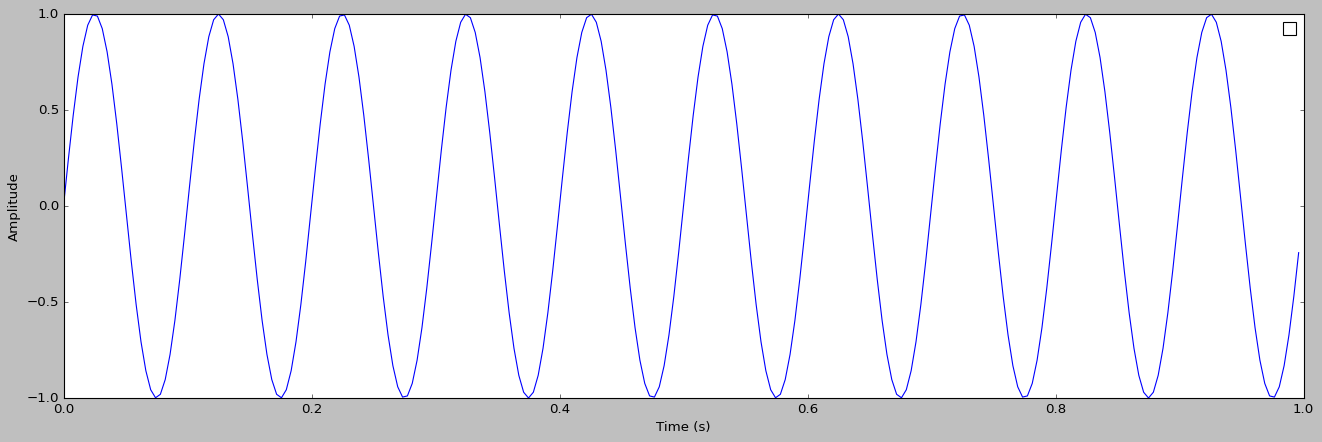

In [71]:
frequency = 10 #Hz
sample_rate = 256 #samples per second
duration = 1 # second

x, y = get_wave(frequency, sample_rate, duration)
plt.figure(figsize=(20,6))
plt.plot(x,y, 'b')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.legend()


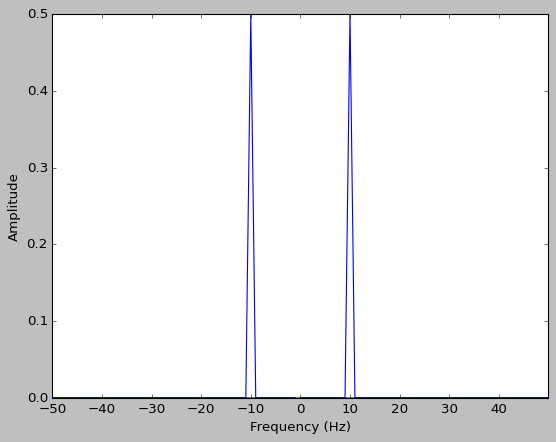

In [72]:
plt.plot(np.fft.fftfreq(sample_rate, d=1/sample_rate), abs(np.fft.fft(y))/256)
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.xlim(-50,50)
plt.xticks(range(-50,50, 10));

- Es importante notar la frecuencia negativa.

In [73]:
file_path = 'D:\\Datos\\full\\underhang\\ball_fault\\0g\\13.1072.csv'
input_data = np.genfromtxt(file_path, delimiter=",")
data = input_data[:,7][:50000]
raw_fft = np.fft.fft(data)
raw_freq = np.fft.fftfreq(data.shape[0], d=1/data.shape[0])

Text(0.5, 0, 'Time (s)')

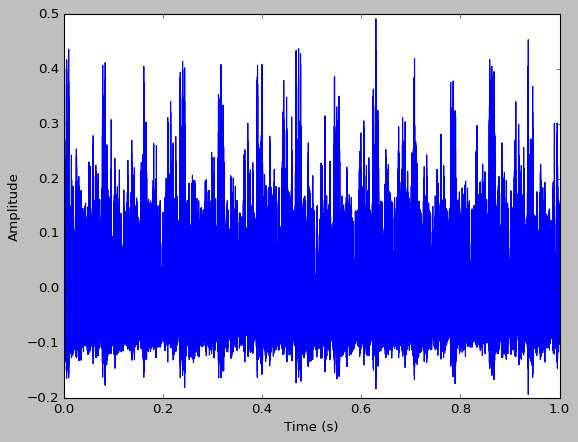

In [74]:
plt.plot(np.linspace(0, 1, 50000), data)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Frequency (Hz)')

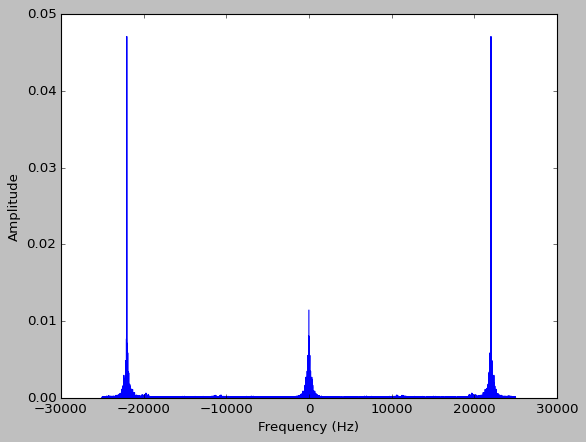

In [75]:
plt.plot(raw_freq, abs(raw_fft)/data.shape[0])
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')

## 1.1. Aliasing

## Ejemplo simple

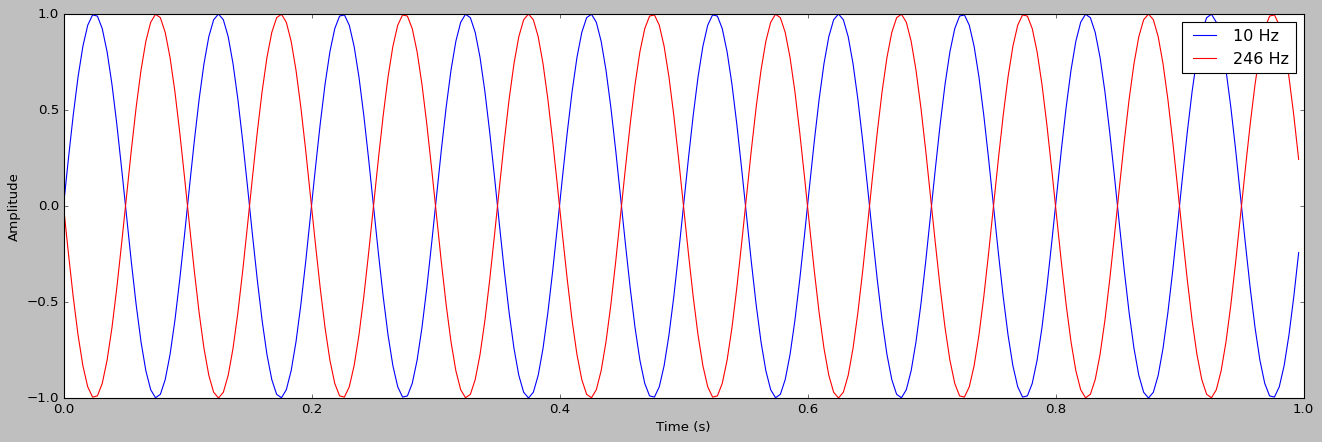

In [76]:
x_246, y_246 = get_wave(246, sample_rate, duration)
plt.figure(figsize=(20,6))
plt.plot(x,y, 'b', label='10 Hz')
plt.plot(x_246, y_246, 'r', label='246 Hz')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.legend()

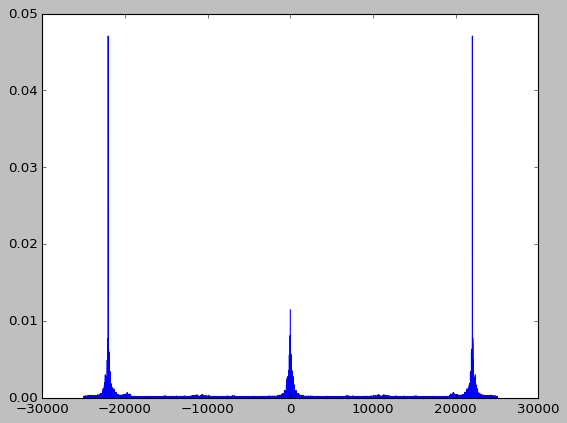

In [77]:
plt.plot(raw_freq, abs(raw_fft)/data.shape[0])

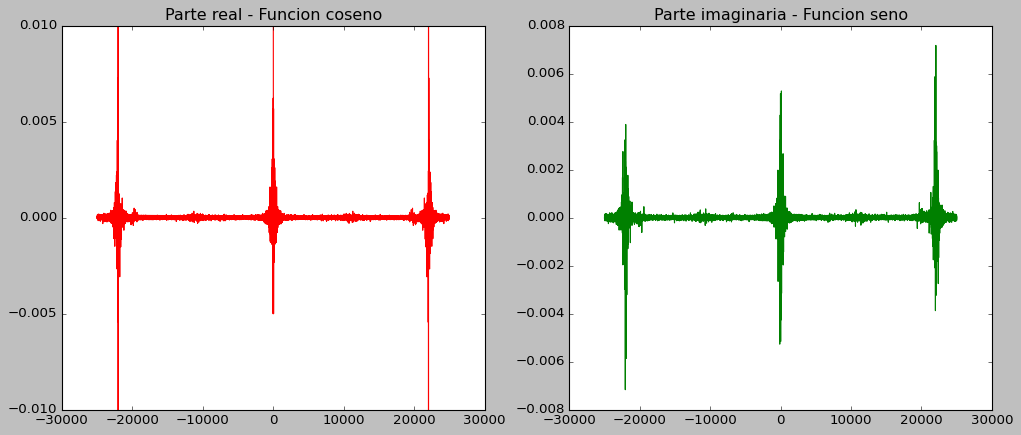

In [78]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(15)
axis[0].plot(raw_freq, raw_fft.real/data.shape[0], 'r')
axis[0].set_ylim([-0.01, 0.01])
axis[0].set_title("Parte real - Funcion coseno")

axis[1].plot(raw_freq, raw_fft.imag/data.shape[0], 'g')
axis[1].set_title("Parte imaginaria - Funcion seno")
plt.show() 

# 2. Transformada de Hilbert

 $$
 \begin{align}
  H({\omega}) =
    \begin{cases}
      1, & \omega > 0\\
      0, & \omega = 0\\
      -1, & \omega < 0
    \end{cases}       
\end{align}
$$

Numericamente y usando la transforma discreta de Fourier se aproxima la transformada de Hilbert con los siguientes valores

 $$
 \begin{align}
  H({\omega}) =
    \begin{cases}
      2, & f < f_N\\
      0, & f >  f_N\\
      1, & f = 0
    \end{cases}       
\end{align}
$$

Donde $f_N$ es la frecuencia de Nyquist

## 2.1. Ejemplo simple

In [79]:
x, y = get_wave(frequency, sample_rate, duration)
y += 0.5*np.random.normal(size=len(x))

# 3. Señal Analítica (Análisis de envolvente)

La señal analítica se define como

$$
\begin{align}
z(t) = s(t) + i \hat{s}(t)
\end{align}
$$

Donde $\hat{s}$ es la transformada de Hilbert

## 3.1. Ejemplo simple

In [80]:
y_analytic_signal = get_analytic_signal2(y)
y_envelope = get_amplitude_envelope(y_analytic_signal)
y_instantaneous_phase = get_instantaneous_phase(y_analytic_signal)
y_intantaneous_frequency = get_intantaneous_frequency(y_instantaneous_phase)

c:\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


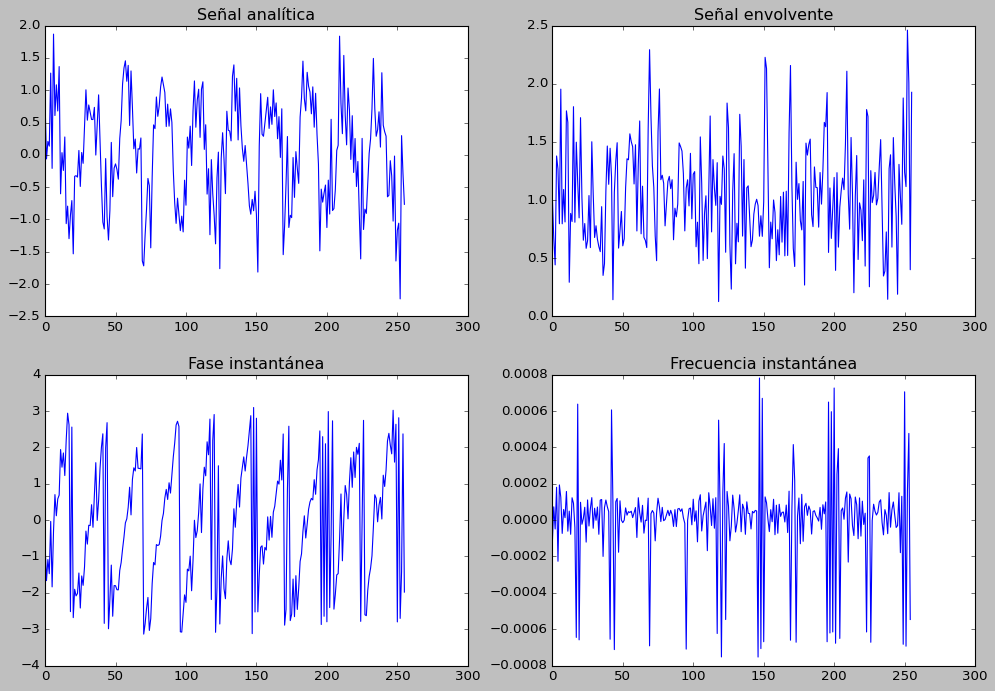

In [81]:
fig, axis = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
axis[0, 0].plot(y_analytic_signal)
axis[0, 0].set_title("Señal analítica")

axis[0, 1].plot(y_envelope)
axis[0, 1].set_title("Señal envolvente")

axis[1, 0].plot(y_instantaneous_phase)
axis[1, 0].set_title("Fase instantánea")

axis[1, 1].plot(y_intantaneous_frequency)
axis[1, 1].set_title("Frecuencia instantánea")
plt.show() 

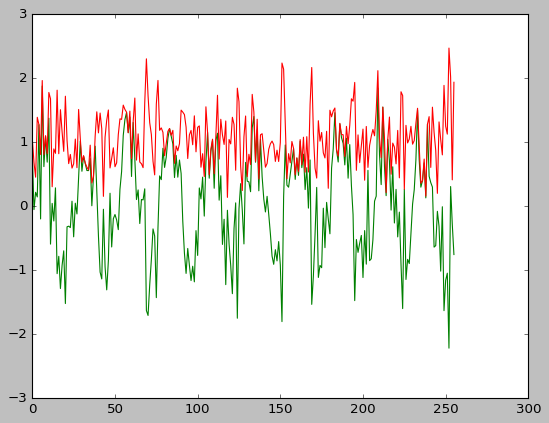

In [82]:
plt.plot(y, 'g')
plt.plot(y_envelope, 'r')

In [83]:
y_analytic_signal = get_analytic_signal2(data)
y_envelope = get_amplitude_envelope(y_analytic_signal)
y_instantaneous_phase = get_instantaneous_phase(y_analytic_signal)
y_intantaneous_frequency = get_intantaneous_frequency(y_instantaneous_phase)

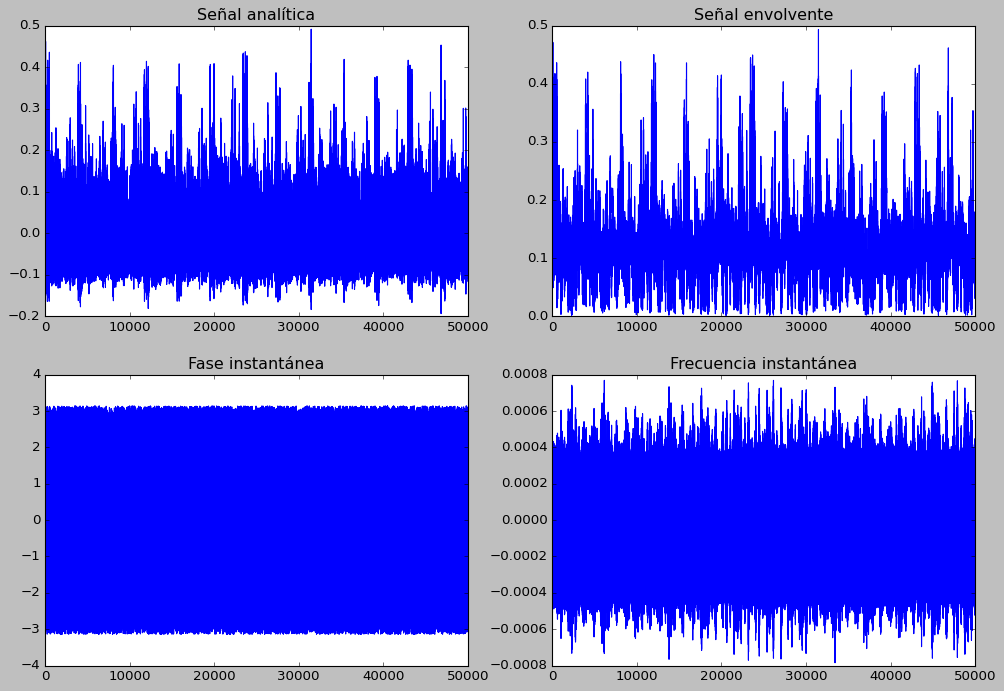

In [84]:
fig, axis = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
axis[0, 0].plot(y_analytic_signal)
axis[0, 0].set_title("Señal analítica")

axis[0, 1].plot(y_envelope)
axis[0, 1].set_title("Señal envolvente")

axis[1, 0].plot(y_instantaneous_phase)
axis[1, 0].set_title("Fase instantánea")

axis[1, 1].plot(y_intantaneous_frequency)
axis[1, 1].set_title("Frecuencia instantánea")
plt.show() 

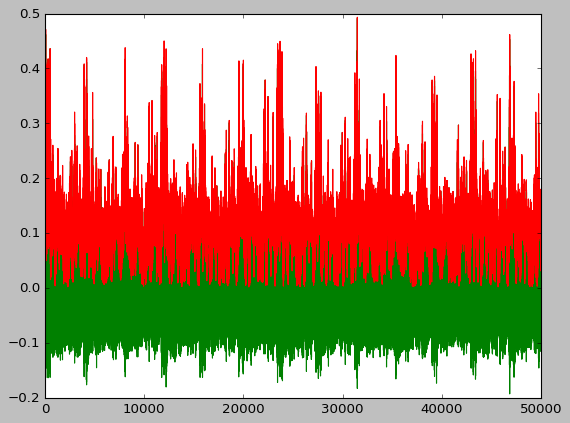

In [85]:
plt.plot(data, 'g')
plt.plot(y_envelope, 'r')

(0.0, 50.0)

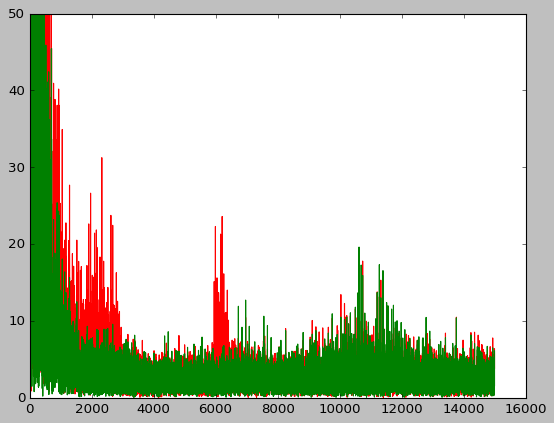

In [86]:
plt.plot(abs(np.fft.fft(y_envelope)[0:len(data)//2])[0:15000], 'r')
plt.plot(abs(np.fft.fft(data)[0:len(data)//2])[0:15000], 'g')
plt.ylim([0, 50])

# 4. Decomposición empírica de modos

In [87]:
def sifting_imf(signal):
    imf = signal
    standard_deviation = float('inf')

    while standard_deviation > 0.2:
        maxima, minima = identify_extrema(imf)
        upper_envelope = CubicSpline(maxima[:,0], maxima[:,1])(np.arange(len(signal)))
        lower_envelope = CubicSpline(minima[:,0], minima[:,1])(np.arange(len(signal)))

        mean_envelope = (upper_envelope + lower_envelope)/2
        previous_imf = imf
        imf = imf - mean_envelope
        standard_deviation = np.sum(previous_imf - imf)**2 / np.sum(previous_imf**2)

    return imf
    
def identify_extrema(signal):
    delta = np.diff(signal)
    maxima = np.array([[i, signal[i]] for i in range(1, len(delta)) if delta[i-1] > 0 > delta[i]])
    minima = np.array([[i, signal[i]] for i in range(1, len(delta)) if delta[i-1] < 0 < delta[i]])

    return maxima, minima

def emphirical_decomposition_mode(signal, max_imfs=10):
    imfs=[]
    residual = signal

    for _ in range(max_imfs):
        imf = sifting_imf(residual)
        imfs.append(imf)
        residual = residual - imf

        if np.all(np.abs(residual) < 1e-2):
            break
    
    return imfs, residual

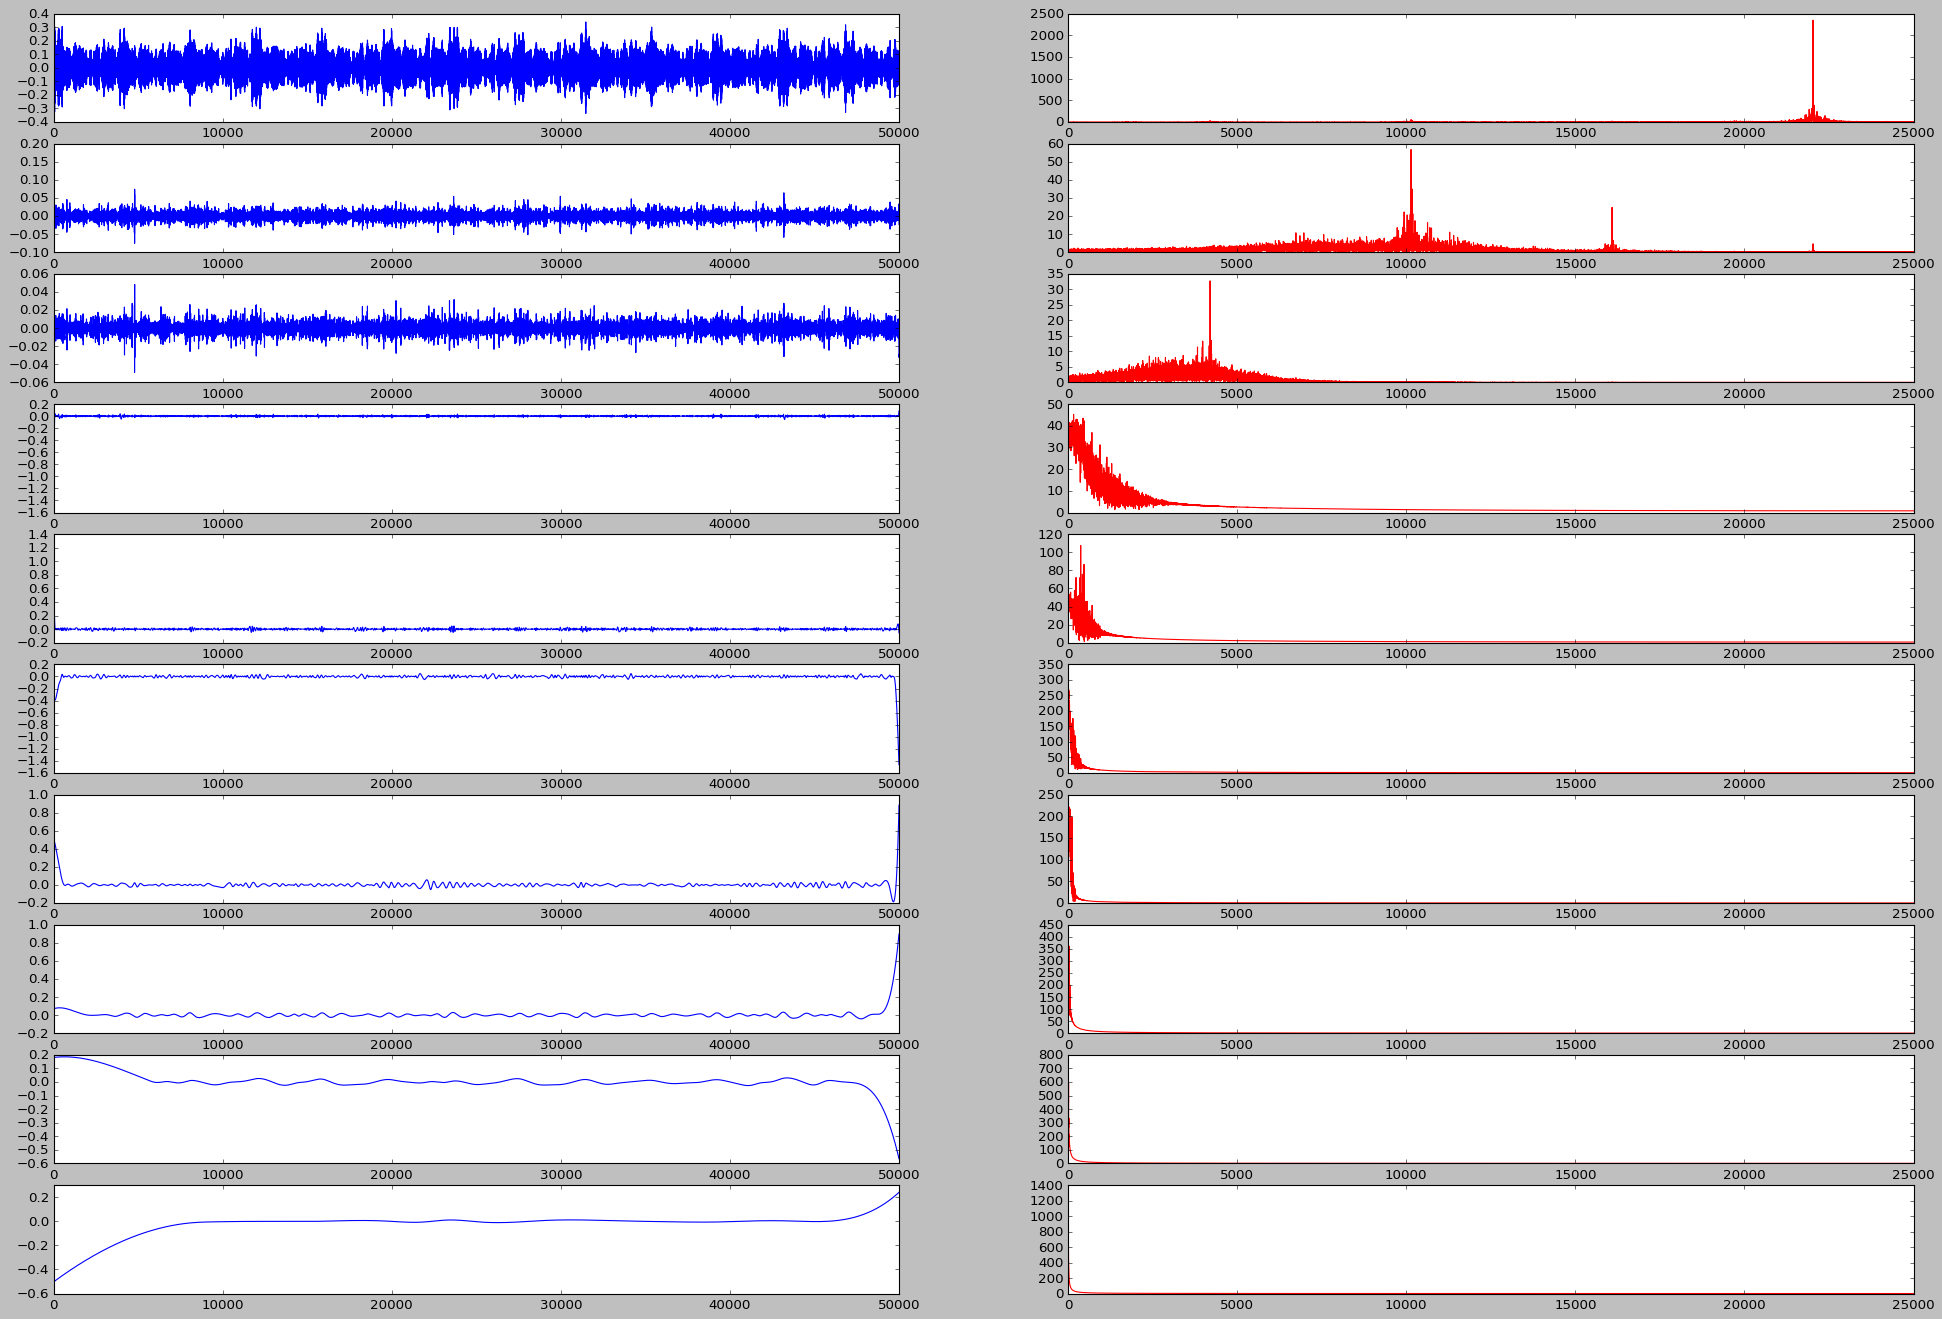

In [102]:
fig, axis = plt.subplots(10, 2)
fig.set_figwidth(30)
fig.set_figheight(20)
for i in range(10):
    axis[i, 0].plot(imfs[i])
    axis[i, 1].plot(abs(np.fft.fft(imfs[i]))[0:25000], color='r')
plt.show() 